In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
import sys
sys.path.append('../../../src')

from common import common, transform, json
from common.json import TRACKING_FORMAT
from common.keypoint import KeypointsList
from individual_activity.individual_activity import IndividualActivity

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams["font.size"] = 20
plt.rcParams['xtick.direction'] = 'in'  # x axis in
plt.rcParams['ytick.direction'] = 'in'  # y axis in

In [2]:
room_num = '09'
date = '20210304'
file_names = [f'gaze{i}-{j}' for i in range(1, 4) for j in range(1, 4)]
names = [f'GA{i}-O{j}' for i in range(1, 4) for j in range(1, 4)]
recalls = {
    names[0]: 0.929,
    names[1]: 0.235,
    names[2]: 0.037,
    names[3]: 1.000,
    names[4]: 0.235,
    names[5]: 0.638,
    names[6]: 0.945,
    names[7]: 0.912,
    names[8]: 0.260,
}
manual_results = {
    file_names[0]: {'frame': 350, 'order': [0, 2, 1]},
    file_names[1]: {'frame': 310, 'order': [0, 1, 2]},
    file_names[2]: {'frame': 275, 'order': [0, 1, 2]},
    file_names[3]: {'frame': 276, 'order': [0, 1, 2]},
    file_names[4]: {'frame': 286, 'order': [0, 1, 2]},
    file_names[5]: {'frame': 283, 'order': [0, 1, 2]},
    file_names[6]: {'frame': 311, 'order': [0, 1, 2]},
    file_names[7]: {'frame': 297, 'order': [0, 1, 2]},
    file_names[8]: {'frame': 305, 'order': [0, 1, 2]},
}
test_parts = ['Nose', 'LEar', 'REar']

In [3]:
def load_keypoints(name):
    keypoints_list = KeypointsList()
    tracking_json = os.path.join(
        common.data_dir, '{0}/{1}/{2}/json/tracking.json'.format(room_num, date, name))
    tracking_datas = json.load(tracking_json)
    
    for item in tracking_datas:
        frame_num = item[TRACKING_FORMAT[1]]
        if frame_num >= manual_results[name]['frame']:
            # frame numberが全員が同じ方向を見るタイミング以降を加える
            keypoints = np.array(item[TRACKING_FORMAT[2]])
            keypoints_list.append(keypoints)
            
    return keypoints_list

In [4]:
keypoints_dict = {}
for name, file_name in zip(names, file_names):
    keypoints_dict[name] = load_keypoints(file_name)

# ABE2021 Reviewer2 Point2 (a)

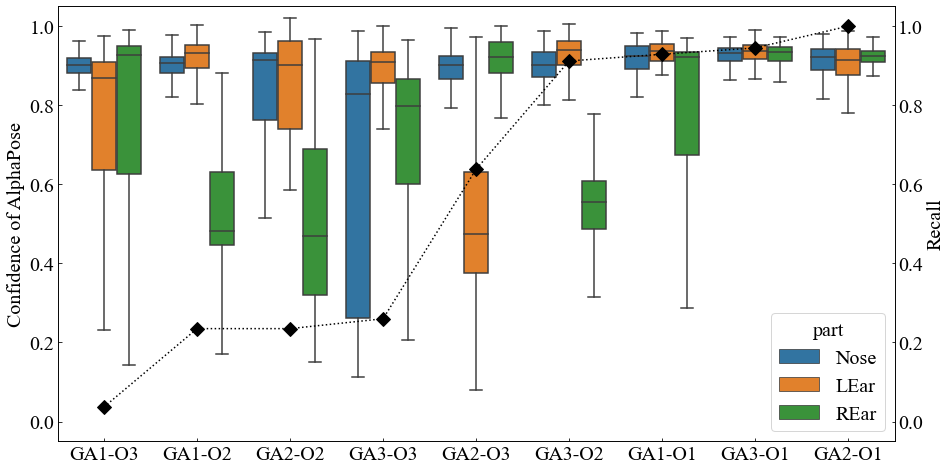

In [9]:
df_lst = []
sorted_recalls = dict(sorted(recalls.items(), key=lambda x: x[1]))
sorted_names = list(sorted_recalls.keys())

for part in test_parts:
    # 体のパーツごとに信頼度を計算する
    conf_dict = {name: [] for name in sorted_names}
    max_conf_len = 0
    for name in sorted_names:
        recall = recalls[name]
        keypoints_list = keypoints_dict[name]
        confs = conf_dict[name]
        
        for keypoints in keypoints_list:
            # keypointsから信頼度のみ取得
            conf = keypoints.get(part)[2]
            confs.append(conf)
            
        if len(confs) > max_conf_len:
            max_conf_len = len(confs)
    
    # 配列が全て同じ長さになるようにNoneでパディング
    for confs in conf_dict.values():
        confs += [None for _ in range(max_conf_len - len(confs))]
        
    # https://stats.biopapyrus.jp/python/boxplot.html
    df = pd.DataFrame.from_dict(conf_dict)
    df = pd.melt(df)
    df['part'] = part
    df_lst.append(df)
    
df = pd.concat(df_lst, axis=0)
    
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(1, 1, 1)
sns.boxplot(x='variable', y='value', hue='part', showfliers=False, data=df, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Confidence of AlphaPose')
ax.set_ylim(-0.05, 1.05)

ax2 = ax.twinx()
ax2.plot(
    sorted_recalls.keys(), sorted_recalls.values(),
    color='black', marker='D', markersize=10, linestyle=':')
ax2.set_xlabel('')
ax2.set_ylabel('Recall')
ax2.set_ylim(-0.05, 1.05)

plt.savefig(f'../images/a.pdf')
plt.show()

# ABE2021 Reviewer2 Point2 (b)

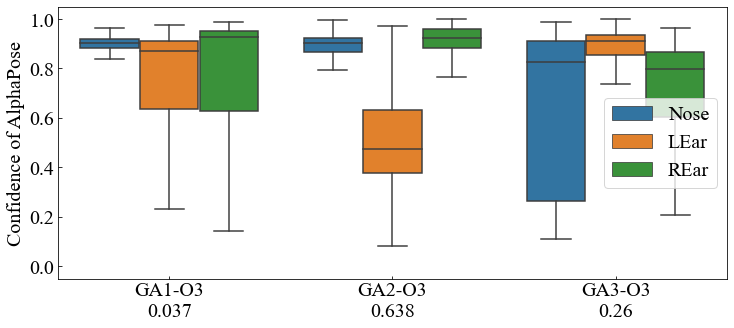

In [6]:
df_lst = []
for part in test_parts:
    # 体のパーツごとに信頼度を計算する
    conf_dict = {}
    max_conf_len = 0
    for name in ['GA1-O3', 'GA2-O3', 'GA3-O3']:
        recall = recalls[name]
        keypoints_list = keypoints_dict[name]

        key = f'{name}\n{recall}'
        if key not in conf_dict:
            conf_dict[key] = []
        confs = conf_dict[key]
        
        for keypoints in keypoints_list:
            # keypointsから信頼度のみ取得
            conf = keypoints.get(part)[2]
            confs.append(conf)
            
        if len(confs) > max_conf_len:
            max_conf_len = len(confs)
    
    # 配列が全て同じ長さになるようにNoneでパディング
    for confs in conf_dict.values():
        confs += [None for _ in range(max_conf_len - len(confs))]
    
    # https://stats.biopapyrus.jp/python/boxplot.html
    df = pd.DataFrame.from_dict(conf_dict)
    df = pd.melt(df)
    df['part'] = part
    df_lst.append(df)
    
df = pd.concat(df_lst, axis=0)
    
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 1, 1)
sns.boxplot(x='variable', y='value', hue='part', showfliers=False, data=df, ax=ax)
#     sns.boxplot(x='variable', y='value', data=df, showfliers=False, ax=ax)
#     sns.stripplot(x='variable', y='value', data=df, jitter=True, color='black', alpha=0.2, ax=ax)
plt.xlabel('')
plt.ylabel('Confidence of AlphaPose')
plt.ylim(-0.05, 1.05)
plt.legend()
# plt.legend(bbox_to_anchor=(0.01, 0.29), loc='upper left', borderaxespad=0)
plt.savefig(f'../images/b.pdf')
plt.show()

# ABE2021 Reviewer2 Point2 (c)

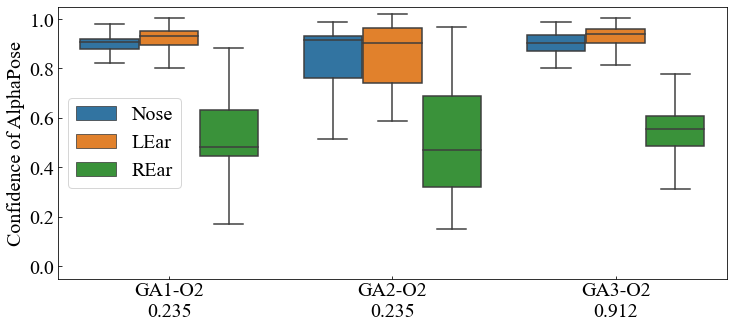

In [7]:
df_lst = []
for part in test_parts:
    # 体のパーツごとに信頼度を計算する
    conf_dict = {}
    max_conf_len = 0
    for name in ['GA1-O2', 'GA2-O2', 'GA3-O2']:
        recall = recalls[name]
        keypoints_list = keypoints_dict[name]

        key = f'{name}\n{recall}'
        if key not in conf_dict:
            conf_dict[key] = []
        confs = conf_dict[key]
        
        for keypoints in keypoints_list:
            # keypointsから信頼度のみ取得
            conf = keypoints.get(part)[2]
            confs.append(conf)
            
        if len(confs) > max_conf_len:
            max_conf_len = len(confs)
    
    # 配列が全て同じ長さになるようにNoneでパディング
    for confs in conf_dict.values():
        confs += [None for _ in range(max_conf_len - len(confs))]
    
    # https://stats.biopapyrus.jp/python/boxplot.html
    df = pd.DataFrame.from_dict(conf_dict)
    df = pd.melt(df)
    df['part'] = part
    df_lst.append(df)
    
df = pd.concat(df_lst, axis=0)
    
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 1, 1)
sns.boxplot(x='variable', y='value', hue='part', showfliers=False, data=df, ax=ax)
#     sns.boxplot(x='variable', y='value', data=df, showfliers=False, ax=ax)
#     sns.stripplot(x='variable', y='value', data=df, jitter=True, color='black', alpha=0.2, ax=ax)
plt.xlabel('')
plt.ylabel('Confidence of AlphaPose')
plt.ylim(-0.05, 1.05)
# plt.legend(bbox_to_anchor=(0.01, 0.29), loc='upper left', borderaxespad=0)
plt.legend()
plt.savefig(f'../images/c.pdf')
plt.show()